# Exercise 4  -  Clustering with scikit-learn

Guadagnini Michele - 1230663

Lambertini Alessandro - 1242885

Pagano Alice - 1236916

Puppin Michele - 1227474

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True) 

In [2]:
df = pd.read_table("data_t-SNE_310101_d5_R100_e1_N800.dat", sep="\t", header=None)


print('Shape of the dataframe:', df.shape)

N = df.shape[0]

Shape of the dataframe: (800, 5)


In [3]:
df.head()

,0,1,2,3,4
0,-83065,29521,68815,-100340,-29235
1,-110304,38545,68519,-115776,-46287
2,-88908,31418,69174,-107023,-30120
3,-99298,32751,71580,-113674,-38766
4,-77225,29431,64216,-95754,-28018


## A - Introduction of dataset adn 3D visualization

In [4]:
N_red = int(0.1*N)
N_green = int(0.3*N)
N_blue = int(0.6*N)

red_df = df[:N_red]
green_df = df[N_red:N_red+N_green]
blue_df = df[N_red+N_green:N]

print('Shape of the red dataset:', red_df.shape)
print('Shape of the green dataset:', green_df.shape)
print('Shape of the blue dataset:', blue_df.shape)

ytrue = [0]*N_red + [1]*N_green + [2]*N_blue

Shape of the red dataset: (80, 5)
Shape of the green dataset: (240, 5)
Shape of the blue dataset: (480, 5)


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


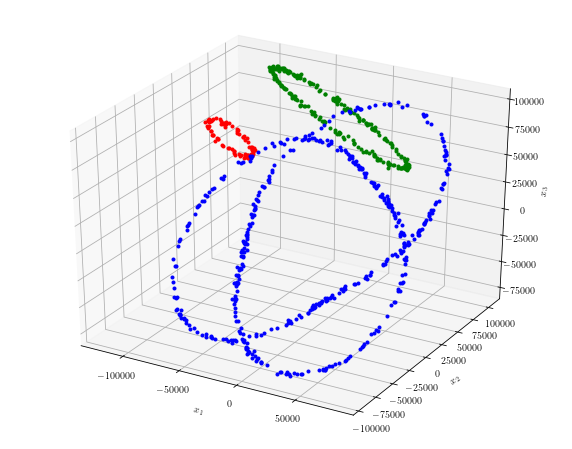

In [5]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')

ax.plot(red_df[0],red_df[1],red_df[2],'.',color='red')
ax.plot(green_df[0],green_df[1],green_df[2],'.',color='green')
ax.plot(blue_df[0],blue_df[1],blue_df[2],'.',color='blue')

#ax.set_title('3d plot of first 3 dimensions')
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_zlabel('$x_3$')

plt.savefig('3drep.eps', format='eps') 

## B - DBSCAN on 5D

In [6]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from collections import OrderedDict

In [7]:
from sklearn.manifold import TSNE
import numpy as np

In [8]:
np.random.seed(12345)

#X_emb_5 = TSNE(n_components=2, perplexity=5.0).fit_transform(df)
X_emb_30 = TSNE(n_components=2, perplexity=30.0).fit_transform(df)
#X_emb_50 = TSNE(n_components=2, perplexity=50.0).fit_transform(df)
#X_emb_100 = TSNE(n_components=2, perplexity=100.0).fit_transform(df)

In [9]:
def clustering(y):
    # Finds position of labels and returns a dictionary of cluster labels to data indices.
    yu = np.sort(np.unique(y))
    clustering = OrderedDict()
    for ye in yu:
        clustering[ye] = np.where(y == ye)[0]
    return clustering

def entropy(c, n_sample):
    # Measures the entropy of a cluster
    h = 0.
    for kc in c.keys():
        p=len(c[kc])/n_sample
        h+=p*np.log(p)
    h*=-1.
    return h

# Normalized mutual information function
# Note that this deals with the label permutation problem
def NMI(y_true, y_pred):
    """ Computes normalized mutual information: where y_true and y_pred are both clustering assignments
    """
    w = clustering(y_true)
    c = clustering(y_pred)
    n_sample = len(y_true)

    Iwc = 0.
    for kw in w.keys():
        for kc in c.keys():
            w_intersect_c=len(set(w[kw]).intersection(set(c[kc])))
            if w_intersect_c > 0:
                Iwc += w_intersect_c*np.log(n_sample*w_intersect_c/(len(w[kw])*len(c[kc])))
    Iwc/=n_sample
    Hc = entropy(c,n_sample)
    Hw = entropy(w,n_sample)

    return 2*Iwc/(Hc+Hw)


cpalette = ["#1CE6FF", "#FF34FF", "#FF4A46","#008941", "#006FA6", "#A30059", "#0000A6", "#63FFAC","#B79762", "#004D43", "#8FB0FF", "#997D87","#5A0007", "#809693","#1B4400", "#4FC601", "#3B5DFF", "#4A3B53","#886F4C","#34362D", "#B4A8BD", "#00A6AA", "#452C2C","#636375", "#A3C8C9", "#FF913F", "#938A81","#575329", "#00FECF", "#B05B6F"]

def plotting_ax(X, y, ax):
    # plotting function
    for i, yu in enumerate(np.unique(y)):
        pos = (y == yu)
        ax.scatter(X[pos,0], X[pos,1],c=cpalette[i%len(cpalette)],s=4)

In [10]:
# DBSCAN has a few parameters, let's sweep over a few parameters and see what happens
np.random.seed(12345)

X = StandardScaler().fit_transform(df)

# Compute distances between points
min_dist = 1e6

for i in range(X.shape[0]):
    for j in range(X.shape[0]):
        if i>j:
            new_dist = np.sqrt( (X[i,0]-X[j,0])**2 + (X[i,1]-X[j,1])**2 
                        + (X[i,2]-X[j,2])**2 + (X[i,3]-X[j,3])**2 + (X[i,4]-X[j,4])**2 )           
            if new_dist<min_dist:
                min_dist = new_dist    

print('Minimum distance', min_dist) 

Minimum distance 0.011262911638290908


In [11]:
# Compute distances between points
mean_dist = []

for i in range(X.shape[0]):
    dist = []
    for j in range(X.shape[0]):
        new_dist = np.sqrt( (X[i,0]-X[j,0])**2 + (X[i,1]-X[j,1])**2 
                        + (X[i,2]-X[j,2])**2 + (X[i,3]-X[j,3])**2 + (X[i,4]-X[j,4])**2 )           
        dist.append(new_dist) 
    mean_dist.append(np.mean(dist))
        


print('Minimum distance', np.mean(min_dist))

Minimum distance 0.011262911638290908


In [12]:
a = int(np.log(1000))
print(a)

6


In [13]:
def calculate_kn_distance(X,k):

    kn_distance = []
    for i in range(len(X)):
        eucl_dist = []
        for j in range(len(X)):
            eucl_dist.append(np.sqrt( (X[i,0]-X[j,0])**2 + (X[i,1]-X[j,1])**2 
                                + (X[i,2]-X[j,2])**2 + (X[i,3]-X[j,3])**2 + (X[i,4]-X[j,4])**2 )) 

        eucl_dist.sort()
        kn_distance.append(eucl_dist[k])

    return kn_distance

eps_dist = calculate_kn_distance(X,6)

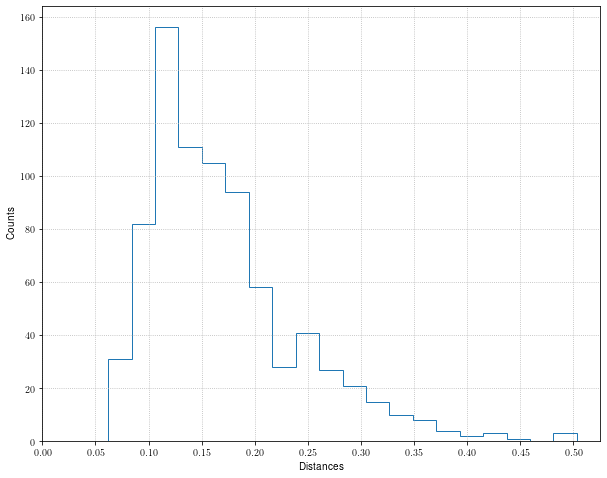

In [14]:
fig = plt.figure(figsize=(10,8))
plt.hist(eps_dist,bins=20,histtype="step")
plt.grid(linestyle='dotted')
plt.ylabel('Counts')
plt.xlabel('Distances')
plt.xticks(np.arange(0, max(eps_dist),0.05 )) 

plt.savefig('kdist.eps', format='eps') 

In [15]:
## CALCOLO dei valori di minPts 




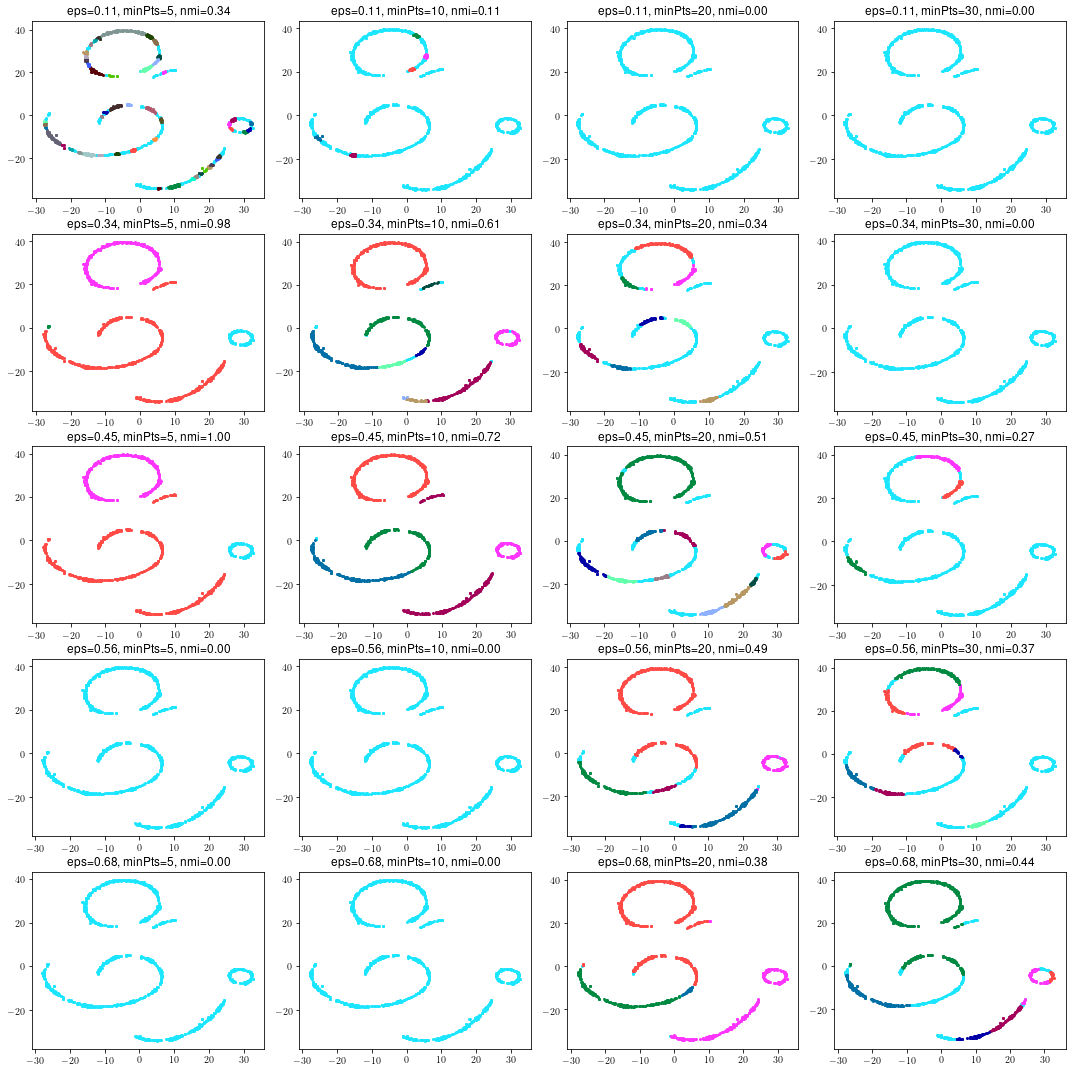

In [16]:
# The epsilon range is chosen as multiple of the minimum distance between points
eps_range = [10*min_dist, 30*min_dist, 40*min_dist, 50*min_dist, 60*min_dist]

min_sample_range = [5,10,20,30]

fig, ax = plt.subplots(len(eps_range),len(min_sample_range),figsize=(15,15))

for i, eps in enumerate(eps_range):    
    for j, min_samples in enumerate(min_sample_range):
        model = DBSCAN(eps=eps, min_samples=min_samples)
        model.fit(X)
        y = model.labels_
        plotting_ax(X_emb_30,y,ax[i,j])
        nmi=NMI(ytrue, y)
        ax[i,j].set_title('eps=%.2f, minPts=%i, nmi=%.2f'%(eps,min_samples,nmi))
        
plt.tight_layout(h_pad=0.5)
plt.show()



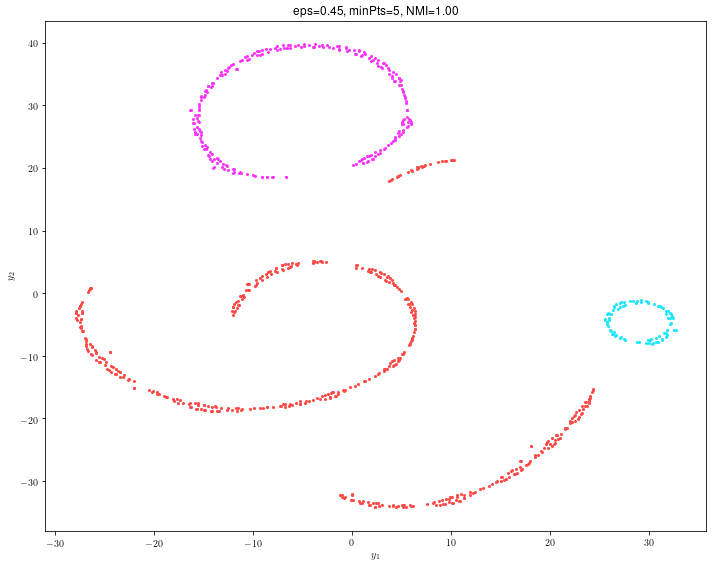

In [17]:
eps = 0.45

min_samples = 5

fig, ax = plt.subplots(figsize=(10,8))


model = DBSCAN(eps=eps, min_samples=min_samples)
model.fit(X)
y = model.labels_
plotting_ax(X_emb_30,y,ax)
nmi=NMI(ytrue, y)
ax.set_title('eps=%.2f, minPts=%i, NMI=%.2f'%(eps,min_samples,nmi))
ax.set_xlabel('$y_1$')
ax.set_ylabel('$y_2$')
        
plt.tight_layout(h_pad=0.5)

plt.savefig('dbscan5dim.eps', format='eps') 

## C - t-SNE algorithm

In [18]:
from sklearn.manifold import TSNE
import numpy as np

In [19]:
np.random.seed(12345)

X_emb_5 = TSNE(n_components=2, perplexity=5.0).fit_transform(df)
X_emb_30 = TSNE(n_components=2, perplexity=30.0).fit_transform(df)
X_emb_50 = TSNE(n_components=2, perplexity=50.0).fit_transform(df)
X_emb_100 = TSNE(n_components=2, perplexity=100.0).fit_transform(df)

Text(0, 0.5, 'y')

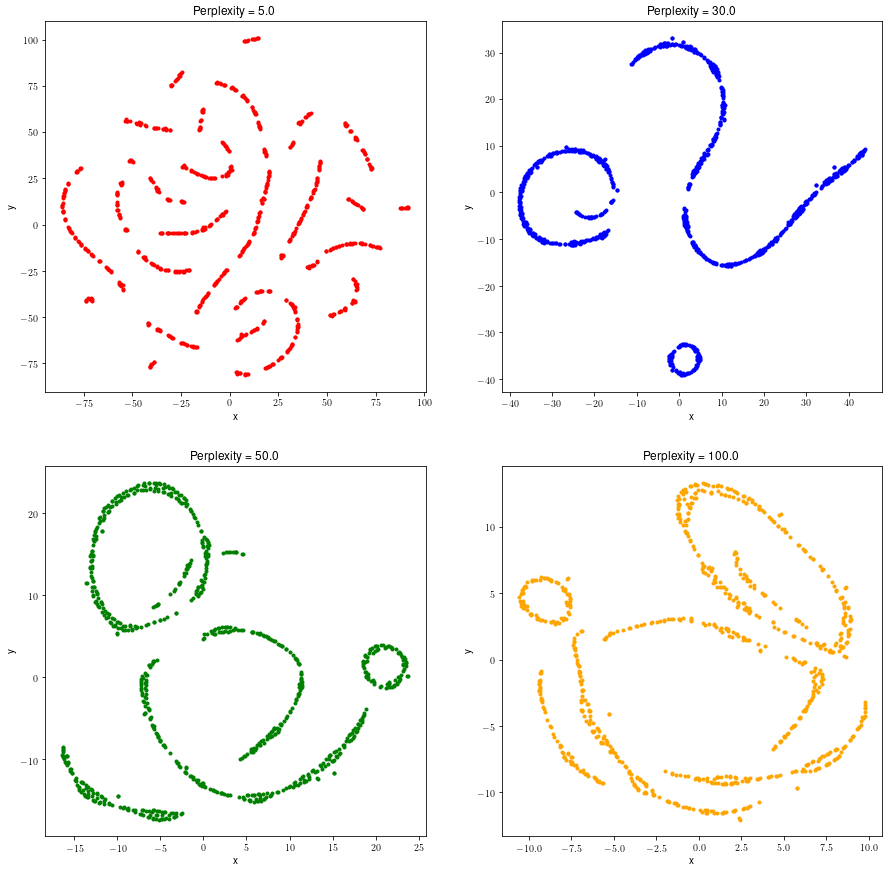

In [20]:
fig = plt.figure(figsize=(15,15))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)

ax1.plot(X_emb_5[:,0],X_emb_5[:,1],'.',color='red')
ax1.set_title('Perplexity = 5.0')
ax2.plot(X_emb_30[:,0],X_emb_30[:,1],'.',color='blue')
ax2.set_title('Perplexity = 30.0')
ax3.plot(X_emb_50[:,0],X_emb_50[:,1],'.',color='green')
ax3.set_title('Perplexity = 50.0')
ax4.plot(X_emb_100[:,0],X_emb_100[:,1],'.',color='orange')
ax4.set_title('Perplexity = 100.0')

ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax3.set_xlabel('x')
ax3.set_ylabel('y')
ax4.set_xlabel('x')
ax4.set_ylabel('y')

## D - DBSCAN in projected data with t-SNE 

In [21]:
# DBSCAN has a few parameters, let's sweep over a few parameters and see what happens
np.random.seed(12345)

X = StandardScaler().fit_transform(X_emb_30) 

# Compute distances between points
min_dist = 1e6

for i in range(X.shape[0]):
    for j in range(X.shape[0]):
        if i>j:
            new_dist = np.sqrt( (X[i,0]-X[j,0])**2 + (X[i,1]-X[j,1])**2  )           
            if new_dist<min_dist:
                min_dist = new_dist    

print('Minimum distance', min_dist) 

Minimum distance 7.916178606635926e-05


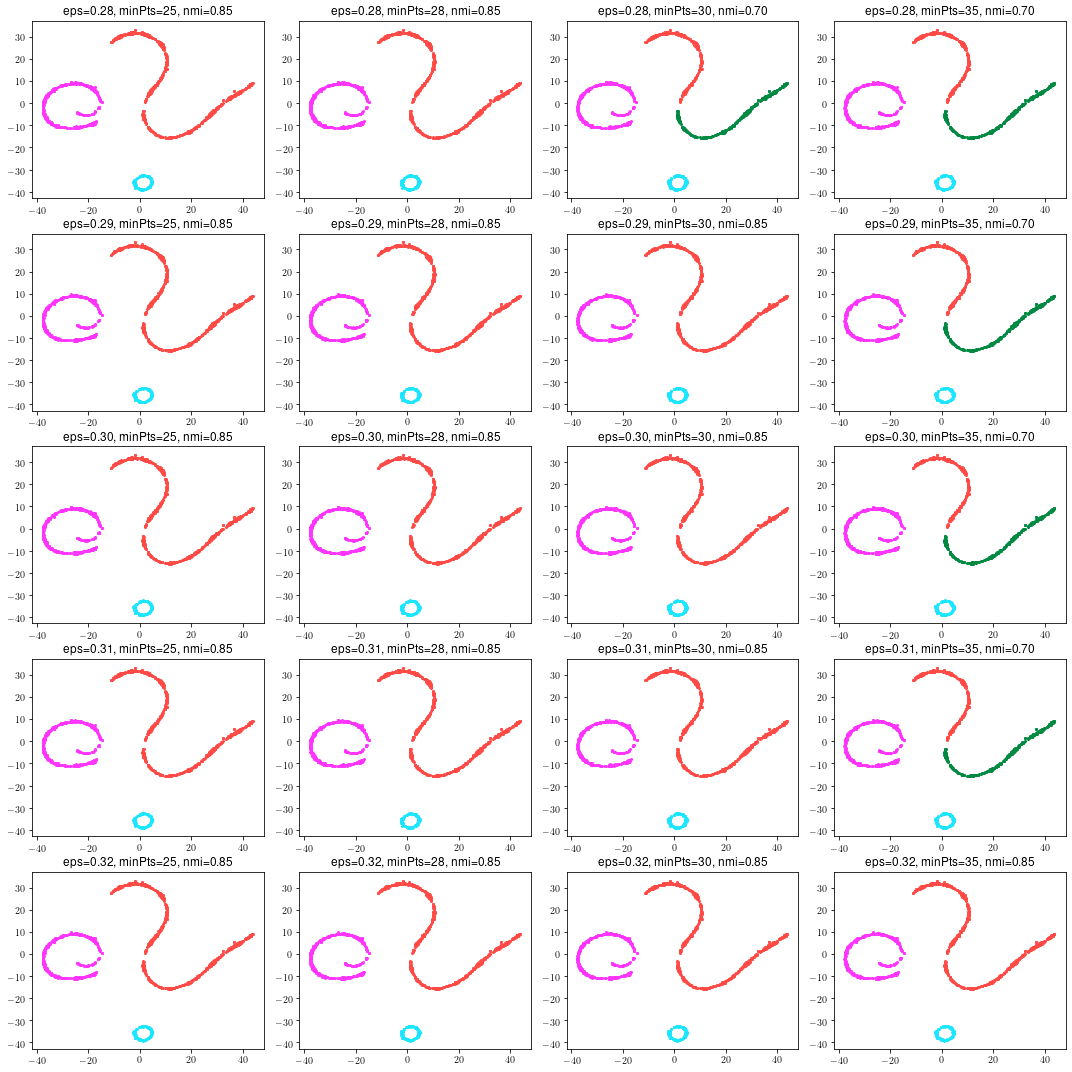

In [22]:
# The epsilon range is chosen as multiple of the minimum distance between points
min_dist = 0.01
eps_range = [28*min_dist, 29*min_dist, 30*min_dist, 31*min_dist, 32*min_dist]

min_sample_range = [25,28,30,35]

fig, ax = plt.subplots(len(eps_range),len(min_sample_range),figsize=(15,15))

for i, eps in enumerate(eps_range):    
    for j, min_samples in enumerate(min_sample_range):
        model = DBSCAN(eps=eps, min_samples=min_samples)
        model.fit(X)
        y = model.labels_
        plotting_ax(X_emb_30,y,ax[i,j])
        nmi=NMI(ytrue, y)
        ax[i,j].set_title('eps=%.2f, minPts=%i, nmi=%.2f'%(eps,min_samples,nmi))
        
plt.tight_layout(h_pad=0.5)
plt.show()

In [23]:
plt.savefig('destination_path.eps', format='eps') 

<Figure size 432x288 with 0 Axes>